In [1]:
# Importing packages and initializing workspace
import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import pylab
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import pickle

train = {}
test = {}

# Loading in all the data
for (curr_1, curr_2) in [('BTC', 'ETH'), ('BTC', 'LTC'), ('BTC', 'XRP'), ('ETH', 'LTC'), ('ETH', 'XRP'), ('LTC', 'XRP')]:
    for interval in ['1min', '10min', '60min', '1d']:
        train[curr_1 + '_' + curr_2 + '_' + interval] = pd.read_csv(curr_1 + '_' + interval + '_' + curr_2 + '_' + interval + '_march.csv')
        test[curr_1 + '_' + curr_2 + '_' + interval] = pd.read_csv(curr_1 + '_' + interval + '_' + curr_2 + '_' + interval + '_april.csv')

# Add in a model of how changes in sentiment can relate to changes in price ratio
for key in train:
    train[key]['Delta Price Ratio'] = train[key]['Price Ratio'].diff().fillna(0)
    train[key]['Delta Polarity'] = train[key]['Net Polarity'].diff().fillna(0)
    train[key]['Delta Subjectivity'] = train[key]['Net Subjectivity'].diff().fillna(0)

for key in test:
    test[key]['Delta Price Ratio'] = test[key]['Price Ratio'].diff().fillna(0)
    test[key]['Delta Polarity'] = test[key]['Net Polarity'].diff().fillna(0)
    test[key]['Delta Subjectivity'] = test[key]['Net Subjectivity'].diff().fillna(0)

In [4]:
# View the data
train['BTC_ETH_10min'].describe()

,BTC Polarity,BTC Subjectivity,BTC Price,BTC Volume USD,ETH Polarity,ETH Subjectivity,ETH Price,ETH Volume USD,Net Polarity,Net Subjectivity,Net Volume,Price Ratio
count,4176.000000,4176.000000,4176.000000,4.176000e+03,4176.000000,4176.000000,4176.000000,4.176000e+03,4176.000000,4176.000000,4.176000e+03,4176.000000
mean,0.094017,0.269118,57184.821705,1.952553e+05,0.085404,0.298091,2256.667598,1.017508e+05,0.008613,-0.028973,9.350450e+04,0.039689
std,0.025300,0.033535,3746.602933,3.687592e+05,0.038747,0.054245,208.750991,2.693004e+05,0.038127,0.050793,4.025291e+05,0.005037
min,0.030123,0.158382,47602.970000,0.000000e+00,-0.052134,0.096006,1900.700000,0.000000e+00,-0.211790,-0.249894,-7.017248e+06,0.032484
25%,0.078008,0.248943,54789.807500,3.000483e+04,0.060670,0.263438,2095.455000,1.091595e+04,-0.015354,-0.061331,-1.072033e+04,0.035666
50%,0.090165,0.265813,57761.075000,8.623771e+04,0.083446,0.296303,2206.225000,3.815813e+04,0.007675,-0.028064,3.152288e+04,0.038558
75%,0.104896,0.285139,59686.317500,2.092018e+05,0.108671,0.329425,2412.085000,1.012290e+05,0.031564,0.004541,1.338265e+05,0.044723
max,0.265464,0.457544,64686.440000,8.880817e+06,0.294725,0.559768,2800.260000,7.571108e+06,0.210835,0.180359,8.382982e+06,0.051858


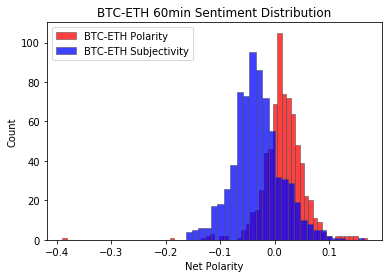

None

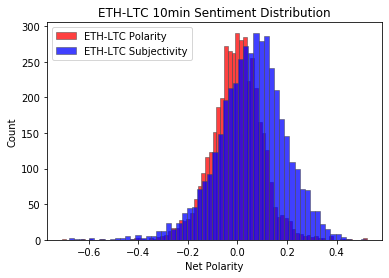

None

In [11]:
# A histogram of the net sentiment for BTC - ETH
sns.histplot(data=train['BTC_ETH_60min'], x='Net Polarity', color='red', edgecolor=".3", linewidth=.5, label='BTC-ETH Polarity')
sns.histplot(data=train['BTC_ETH_60min'], x='Net Subjectivity', color='blue', edgecolor=".3", linewidth=.5, label='BTC-ETH Subjectivity')
plt.title('BTC-ETH 60min Sentiment Distribution')
plt.legend()
display(plt.show())

sns.histplot(data=train['ETH_LTC_10min'], x='Net Polarity', color='red', edgecolor=".3", linewidth=.5, label='ETH-LTC Polarity')
sns.histplot(data=train['ETH_LTC_10min'], x='Net Subjectivity', color='blue', edgecolor=".3", linewidth=.5, label='ETH-LTC Subjectivity')
plt.title('ETH-LTC 10min Sentiment Distribution')
plt.legend()
display(plt.show())

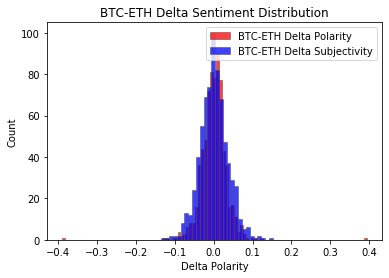

None

In [7]:
# A histogram of the net sentiment for BTC - ETH
sns.histplot(data=train['BTC_ETH_60min'], x='Delta Polarity', color='red', edgecolor=".3", linewidth=.5, label='BTC-ETH Delta Polarity')
sns.histplot(data=train['BTC_ETH_60min'], x='Delta Subjectivity', color='blue', edgecolor=".3", linewidth=.5, label='BTC-ETH Delta Subjectivity')
plt.title('BTC-ETH Delta Sentiment Distribution')
plt.legend()
display(plt.show())

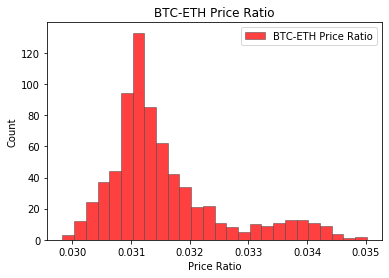

None

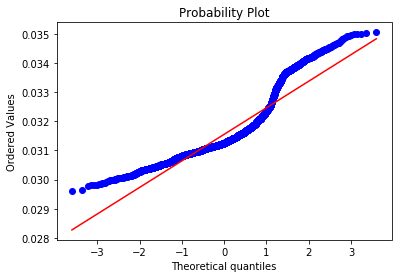

In [9]:
# A histogram of the net sentiment for BTC - ETH
sns.histplot(data=train['BTC_ETH_60min'], x='Price Ratio', color='red', edgecolor=".3", linewidth=.5, label='BTC-ETH Price Ratio')
plt.title('BTC-ETH Price Ratio')
plt.legend()
display(plt.show())

# A Q-Q plot of the BTC-ETH Price Ratio
st.probplot(train['BTC_ETH_10min']['Price Ratio'], dist="norm", plot=pylab)
pylab.show()

In [59]:
# Find correlations
for key in train:
    mask = ~np.isnan(train[key]['Net Polarity']) &  ~np.isnan(train[key]['Price Ratio'])
    corr1, p1 = st.pearsonr(train[key]['Net Polarity'][mask], train[key]['Price Ratio'][mask])
    print(f'{key} Net Polarity Correlation: {corr1}, P-value: {p1}')

    mask = ~np.isnan(train[key]['Net Subjectivity']) &  ~np.isnan(train[key]['Price Ratio'])
    corr2, p2 = st.pearsonr(train[key]['Net Subjectivity'][mask], train[key]['Price Ratio'][mask])
    print(f'{key} Net Subjectivity Correlation: {corr2}, P-value: {p2}')

    mask = ~np.isnan(train[key]['Delta Polarity']) &  ~np.isnan(train[key]['Delta Price Ratio'])
    corr3, p3 = st.pearsonr(train[key]['Delta Polarity'][mask], train[key]['Delta Price Ratio'][mask])
    print(f'{key} Delta Polarity Correlation: {corr3}, P-value: {p3}')

    mask = ~np.isnan(train[key]['Delta Subjectivity']) &  ~np.isnan(train[key]['Delta Price Ratio'])
    corr3, p3 = st.pearsonr(train[key]['Delta Subjectivity'][mask], train[key]['Delta Price Ratio'][mask])
    print(f'{key} Delta Polarity Subjectivity: {corr3}, P-value: {p3}')

    print('')

BTC_ETH_1min Net Polarity Correlation: -0.04180536637509539, P-value: 1.345004332990196e-17
BTC_ETH_1min Net Subjectivity Correlation: 0.060309423153388574, P-value: 6.60350422503405e-35
BTC_ETH_1min Delta Polarity Correlation: 0.005728891939756964, P-value: 0.24172391541108088
BTC_ETH_1min Delta Polarity Subjectivity: -0.004306209466872539, P-value: 0.3788793560619373

BTC_ETH_10min Net Polarity Correlation: -0.11049727337890074, P-value: 8.047146625047467e-13
BTC_ETH_10min Net Subjectivity Correlation: 0.15508179072089118, P-value: 6.791316374869268e-24
BTC_ETH_10min Delta Polarity Correlation: -0.02433336862857781, P-value: 0.11589665642081044
BTC_ETH_10min Delta Polarity Subjectivity: 0.00876358525950334, P-value: 0.571283970536537

BTC_ETH_60min Net Polarity Correlation: -0.18652111333982602, P-value: 7.215516692189622e-07
BTC_ETH_60min Net Subjectivity Correlation: 0.24197903062980153, P-value: 9.882051118418774e-11
BTC_ETH_60min Delta Polarity Correlation: 0.054485575819077384, 

In [60]:
# Define a new matrix with only the selected features

for key in train:
    print(f'{key} Correlation:')
    select_data_btc_eth = train[key][['Net Polarity', 'Net Subjectivity', 'Delta Polarity', 'Delta Subjectivity']]
    display(select_data_btc_eth.corr())


BTC_ETH_1min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.269906,0.678240,0.185518
Net Subjectivity,0.269906,1.000000,0.195520,0.678824
Delta Polarity,0.678240,0.195520,1.000000,0.280789
Delta Subjectivity,0.185518,0.678824,0.280789,1.000000


BTC_ETH_10min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.248486,0.596126,0.143712
Net Subjectivity,0.248486,1.000000,0.158986,0.589339
Delta Polarity,0.596126,0.158986,1.000000,0.255565
Delta Subjectivity,0.143712,0.589339,0.255565,1.000000


BTC_ETH_60min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.301375,0.558976,0.134131
Net Subjectivity,0.301375,1.000000,0.122556,0.497249
Delta Polarity,0.558976,0.122556,1.000000,0.244487
Delta Subjectivity,0.134131,0.497249,0.244487,1.000000


BTC_ETH_1d Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.238711,0.588682,0.267932
Net Subjectivity,0.238711,1.000000,0.226119,0.544621
Delta Polarity,0.588682,0.226119,1.000000,0.508404
Delta Subjectivity,0.267932,0.544621,0.508404,1.000000


BTC_LTC_1min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.459048,0.534210,0.236694
Net Subjectivity,0.459048,1.000000,0.241742,0.545566
Delta Polarity,0.534210,0.241742,1.000000,0.445184
Delta Subjectivity,0.236694,0.545566,0.445184,1.000000


BTC_LTC_10min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.497475,0.644428,0.288659
Net Subjectivity,0.497475,1.000000,0.298583,0.670039
Delta Polarity,0.644428,0.298583,1.000000,0.446508
Delta Subjectivity,0.288659,0.670039,0.446508,1.000000


BTC_LTC_60min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.623007,0.506196,0.212129
Net Subjectivity,0.623007,1.000000,0.243234,0.542858
Delta Polarity,0.506196,0.243234,1.000000,0.434562
Delta Subjectivity,0.212129,0.542858,0.434562,1.000000


BTC_LTC_1d Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.928929,0.360351,0.343848
Net Subjectivity,0.928929,1.000000,0.276015,0.414652
Delta Polarity,0.360351,0.276015,1.000000,0.834887
Delta Subjectivity,0.343848,0.414652,0.834887,1.000000


BTC_XRP_1min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.422977,0.674725,0.253241
Net Subjectivity,0.422977,1.000000,0.261627,0.668203
Delta Polarity,0.674725,0.261627,1.000000,0.383725
Delta Subjectivity,0.253241,0.668203,0.383725,1.000000


BTC_XRP_10min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.582724,0.543081,0.242332
Net Subjectivity,0.582724,1.000000,0.228468,0.534691
Delta Polarity,0.543081,0.228468,1.000000,0.437389
Delta Subjectivity,0.242332,0.534691,0.437389,1.000000


BTC_XRP_60min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.733784,0.378150,0.190000
Net Subjectivity,0.733784,1.000000,0.221867,0.413801
Delta Polarity,0.378150,0.221867,1.000000,0.528076
Delta Subjectivity,0.190000,0.413801,0.528076,1.000000


BTC_XRP_1d Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.900293,0.172166,0.243086
Net Subjectivity,0.900293,1.000000,0.248949,0.444503
Delta Polarity,0.172166,0.248949,1.000000,0.862850
Delta Subjectivity,0.243086,0.444503,0.862850,1.000000


ETH_LTC_1min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.415524,0.540054,0.221898
Net Subjectivity,0.415524,1.000000,0.225511,0.552878
Delta Polarity,0.540054,0.225511,1.000000,0.409169
Delta Subjectivity,0.221898,0.552878,0.409169,1.000000


ETH_LTC_10min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.449254,0.649552,0.265577
Net Subjectivity,0.449254,1.000000,0.272047,0.664225
Delta Polarity,0.649552,0.272047,1.000000,0.408765
Delta Subjectivity,0.265577,0.664225,0.408765,1.000000


ETH_LTC_60min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.551918,0.559392,0.207242
Net Subjectivity,0.551918,1.000000,0.224005,0.537076
Delta Polarity,0.559392,0.224005,1.000000,0.395067
Delta Subjectivity,0.207242,0.537076,0.395067,1.000000


ETH_LTC_1d Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.863122,0.415217,0.372446
Net Subjectivity,0.863122,1.000000,0.257539,0.422115
Delta Polarity,0.415217,0.257539,1.000000,0.793641
Delta Subjectivity,0.372446,0.422115,0.793641,1.000000


ETH_XRP_1min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.314526,0.679504,0.208073
Net Subjectivity,0.314526,1.000000,0.214495,0.673525
Delta Polarity,0.679504,0.214495,1.000000,0.312726
Delta Subjectivity,0.208073,0.673525,0.312726,1.000000


ETH_XRP_10min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.355931,0.580597,0.169683
Net Subjectivity,0.355931,1.000000,0.181380,0.556186
Delta Polarity,0.580597,0.181380,1.000000,0.309973
Delta Subjectivity,0.169683,0.556186,0.309973,1.000000


ETH_XRP_60min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.466330,0.488456,0.151598
Net Subjectivity,0.466330,1.000000,0.129226,0.433487
Delta Polarity,0.488456,0.129226,1.000000,0.315831
Delta Subjectivity,0.151598,0.433487,0.315831,1.000000


ETH_XRP_1d Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.513353,0.481197,0.229877
Net Subjectivity,0.513353,1.000000,0.194887,0.454078
Delta Polarity,0.481197,0.194887,1.000000,0.629771
Delta Subjectivity,0.229877,0.454078,0.629771,1.000000


LTC_XRP_1min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.449204,0.538204,0.233335
Net Subjectivity,0.449204,1.000000,0.244379,0.551649
Delta Polarity,0.538204,0.244379,1.000000,0.438147
Delta Subjectivity,0.233335,0.551649,0.438147,1.000000


LTC_XRP_10min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.476251,0.654896,0.289290
Net Subjectivity,0.476251,1.000000,0.299431,0.680217
Delta Polarity,0.654896,0.299431,1.000000,0.440444
Delta Subjectivity,0.289290,0.680217,0.440444,1.000000


LTC_XRP_60min Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.570246,0.547092,0.252963
Net Subjectivity,0.570246,1.000000,0.253386,0.587649
Delta Polarity,0.547092,0.253386,1.000000,0.446418
Delta Subjectivity,0.252963,0.587649,0.446418,1.000000


LTC_XRP_1d Correlation:


,Net Polarity,Net Subjectivity,Delta Polarity,Delta Subjectivity
Net Polarity,1.000000,0.880655,0.584850,0.537698
Net Subjectivity,0.880655,1.000000,0.537814,0.646924
Delta Polarity,0.584850,0.537814,1.000000,0.880901
Delta Subjectivity,0.537698,0.646924,0.880901,1.000000


In [5]:

ols_model_1 = {}
ols_model_2 = {}
svr = {}
svr_2 = {}
scalar_x = {}
scalar_y = {}

for key in train:
    print(f'{key} Model:')

    # OLS regressions
    if not os.path.exists(f'Models/{key}_ols_1.pickle'):
        ols_model_1[key] = ols("Q(\"Price Ratio\") ~ Q(\"Net Polarity\") + Q(\"Net Subjectivity\")", train[key]).fit()
        ols_model_1[key].save(f'Models/{key}_ols_1.pickle')
    else:
        ols_model_1[key] = pickle.load(open(f'Models/{key}_ols_1.pickle', 'rb'))
    print(ols_model_1[key].summary())

    if not os.path.exists(f'Models/{key}_ols_2.pickle'):
        ols_model_2[key] = ols("Q(\"Delta Price Ratio\") ~ Q(\"Delta Polarity\") + Q(\"Delta Subjectivity\")", train[key]).fit()
        ols_model_2[key].save(f'Models/{key}_ols_2.pickle')
    else:
        ols_model_2[key] = pickle.load(open(f'Models/{key}_ols_2.pickle', 'rb'))
    print(ols_model_2[key].summary())

    # SVR Regression
    scalar_x[key] = StandardScaler()
    scalar_y[key] = StandardScaler()
    X = scalar_x[key].fit_transform(train[key][['Net Polarity', 'Net Subjectivity']])
    y = np.ravel(scalar_y[key].fit_transform(train[key][['Price Ratio']]))
    l_1 = [True if all(val) else False for val in ~np.isnan(X)]
    l_2 = [True if all(val) else False for val in ~np.isinf(X)]
    mask = l_1 &  ~np.isnan(y) & l_2 &  ~np.isinf(y)
    mask = mask.flatten()
    if not os.path.exists(f'Models/{key}_svr.pickle'):
        svr[key] = SVR(kernel='rbf')
        svr[key].fit(X[mask,:],y[mask])
        pickle.dump(svr[key], open(f'Models/{key}_svr.pickle', 'wb'))
        print(f'Saved SVR for: {key}')
    else:
        svr[key] = pickle.load(open(f'Models/{key}_svr.pickle', 'rb'))
        print(f'Loaded: {key}')

    if not os.path.exists(f'Models/{key}_svr_2.pickle'):
        param_grid = {'C': [0.1,1, 10],'kernel': ['rbf', 'poly', 'sigmoid']}
        grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2, scoring='explained_variance')

        grid.fit(X[mask,:],y[mask])
        svr_2[key] = grid.best_estimator_
        pickle.dump(svr_2[key], open(f'Models/{key}_svr_2.pickle', 'wb'))
        print(f'Saved Tuned SVR for: {key}')
    else:
        svr_2[key] = pickle.load(open(f'Models/{key}_svr_2.pickle', 'rb'))
        print(f'Loaded Tuned SVR: {key}')


BTC_ETH_1min Model:
                            OLS Regression Results                            
Dep. Variable:       Q("Price Ratio")   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9353
Date:                Tue, 05 Apr 2022   Prob (F-statistic):              0.392
Time:                        21:01:49   Log-Likelihood:             2.3724e+05
No. Observations:               43058   AIC:                        -4.745e+05
Df Residuals:                   43055   BIC:                        -4.745e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

In [10]:
loaded_model = pickle.load(open('Models/BTC_ETH_1d_svr.pickle', 'rb'))
X = [[i/100,0] for i in range(-100, 100)]
plt.plot(X, scalar_y['BTC_ETH_1d'].inverse_transform(loaded_model.predict(scalar_x['BTC_ETH_1d'].fit_transform(X))), color = 'green')
plt.title('Truth or Bluff (Support Vector Regression Model)')
plt.xlabel('Sentiment')
plt.ylabel('Price Ratio')
plt.show()

KeyboardInterrupt: 

In [6]:
# Use test data to see performance of the models
for key in test:
    prediction_1 = ols_model_1[key].predict(test[key])
    mask = ~np.isnan(test[key]['Price Ratio']) & ~np.isnan(prediction_1) & ~np.isinf(prediction_1)
    print(f'{key} Results:')
    print('Model 1 RMSE: ' + str(rmse(test[key]['Price Ratio'][mask], prediction_1[mask])))

    prediction_2 = ols_model_1[key].predict(test[key])
    mask = ~np.isnan(test[key]['Delta Price Ratio']) & ~np.isnan(prediction_2) & ~np.isinf(prediction_2)
    print('Model 2 RMSE: ' + str(rmse(test[key]['Delta Price Ratio'][mask], prediction_2[mask])))


    input_vec = scalar_x[key].transform(test[key][['Net Polarity', 'Net Subjectivity']])
    mask = ~np.isnan(input_vec) & ~np.isinf(input_vec)
    mask = [True if all(val) else False for val in mask]
    prediction_3 = svr[key].predict(input_vec[mask, :])
    prediction_3 = scalar_y[key].inverse_transform(prediction_3)
    # mask = ~np.isnan(test[key]['Delta Price Ratio']) & ~np.isnan(prediction_3) & ~np.isinf(prediction_3)
    print('SVR Model RMSE: ' + str(rmse(test[key]['Price Ratio'][mask], prediction_3)))

    prediction_4 = svr_2[key].predict(input_vec[mask, :])
    prediction_4 = scalar_y[key].inverse_transform(prediction_4)
    # mask = ~np.isnan(test[key]['Delta Price Ratio']) & ~np.isnan(prediction_3) & ~np.isinf(prediction_3)
    print('SVR Tuned Model RMSE: ' + str(rmse(test[key]['Price Ratio'][mask], prediction_4)))

    mask = ~np.isnan(test[key]['Price Ratio'])
    print('Price ratio Std Dev: ' + str(np.sqrt(test[key]['Price Ratio'][mask].var())))
    mask = ~np.isnan(test[key]['Delta Price Ratio'])
    print('Delta price ratio Std Dev: ' + str(np.sqrt(test[key]['Delta Price Ratio'][mask].var())))
    print('')


BTC_ETH_1min Results:
Model 1 RMSE: 0.009572921393219663
Model 2 RMSE: 0.03155336108388204
SVR Model RMSE: 0.009806686639083002
SVR Tuned Model RMSE: 0.00981050756602975
Price ratio Std Dev: 0.00503698540148251
Delta price ratio Std Dev: 4.403868558636994e-05

BTC_ETH_10min Results:
Model 1 RMSE: 0.009570515937236712
Model 2 RMSE: 0.03154869247224677
SVR Model RMSE: 0.009790962340372732
SVR Tuned Model RMSE: 0.009811987501948673
Price ratio Std Dev: 0.005037438812075876
Delta price ratio Std Dev: 0.0001147965749690192

BTC_ETH_60min Results:
Model 1 RMSE: 0.00956160687611754
Model 2 RMSE: 0.03152703629847584
SVR Model RMSE: 0.009772917887358143
SVR Tuned Model RMSE: 0.009776282806085303
Price ratio Std Dev: 0.005037771694439929
Delta price ratio Std Dev: 0.0002574552569235443

BTC_ETH_1d Results:
Model 1 RMSE: 0.009394744912060512
Model 2 RMSE: 0.03098291824911676
SVR Model RMSE: 0.009483416930676706
SVR Tuned Model RMSE: 0.009578386324732346
Price ratio Std Dev: 0.0049970744949618265


Net Polarity Residual


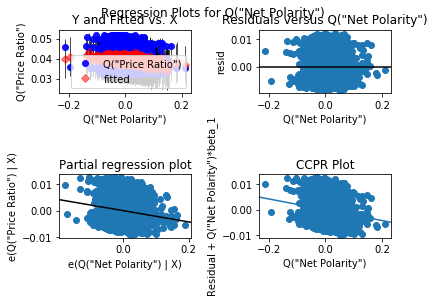

Net Subjectivity Residual


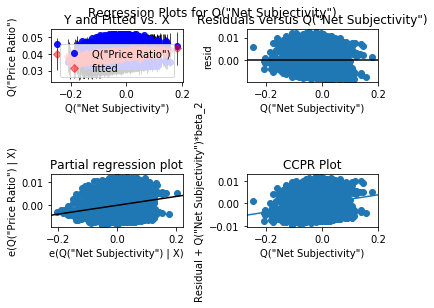

Model 1 Q-Q Plot


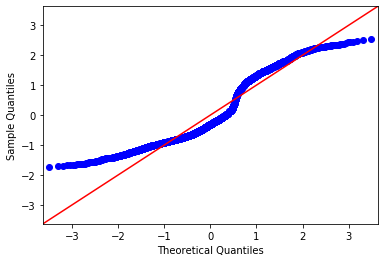

Net Polarity Residual


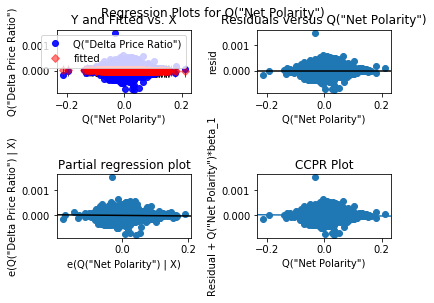

Net Subjectivity Residual


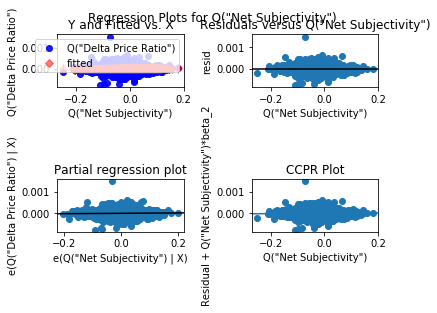

Model 2 Q-Q Plot


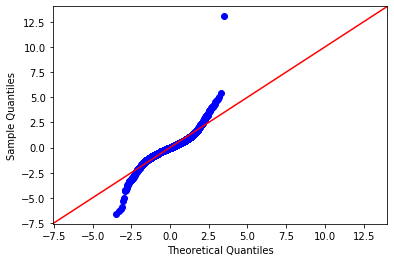

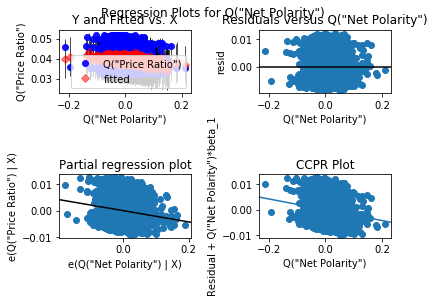

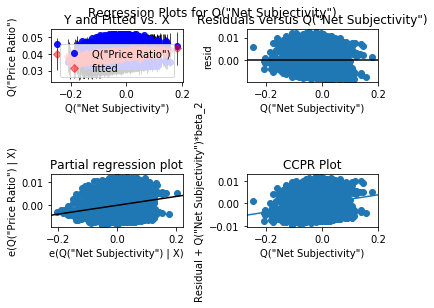

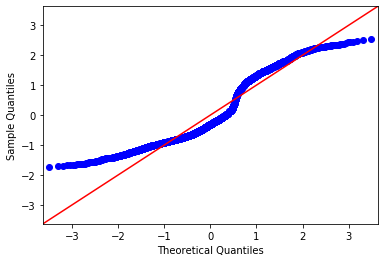

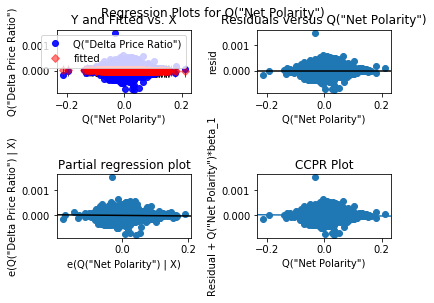

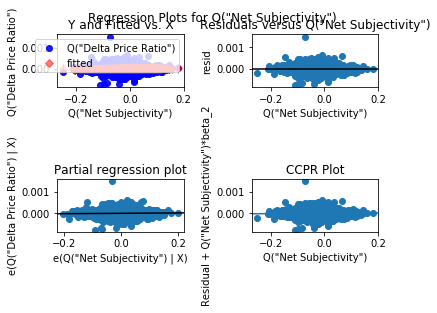

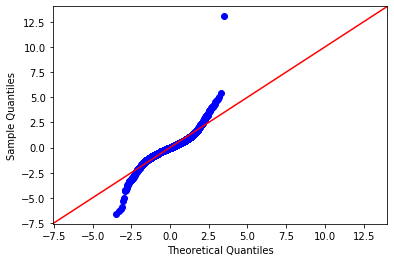

In [41]:
# Consider the residual plots for the models
print('Net Polarity Residual')
display(sm.graphics.plot_regress_exog(ols_model_1['BTC_ETH_10min'], 'Q(\"Net Polarity\")'))
print('Net Subjectivity Residual')
display(sm.graphics.plot_regress_exog(ols_model_1['BTC_ETH_10min'], 'Q(\"Net Subjectivity\")'))

print('Model 1 Q-Q Plot')
display(sm.qqplot(ols_model_1['BTC_ETH_10min'].resid, fit=True, line="45"))